## rule 122 stuff

**quantum circuit parameters**

In [120]:
# Global parameters
n = 5   # Number of spatial cells
m = 3   # Number of time steps
shots = 128

In [121]:
# Rule 122 patterns that should lead to output 1
rule122 = [
    (1, 1, 0),  # 110
    (1, 0, 1),  # 101
    (1, 0, 0),  # 100
    (0, 1, 1),  # 011
    (0, 0, 1),  # 001
]

**classical definition**

In [122]:
def classical_rule122(size=n, steps=m):
    import numpy as np
    grid = np.zeros((steps, size), dtype=np.uint8)
    grid[0, size // 2] = 1
    for t in range(1, steps):
        left = np.roll(grid[t - 1], 1)
        center = grid[t - 1]
        right = np.roll(grid[t - 1], -1)
        neighborhood = (left << 2) | (center << 1) | right
        rule = 0b01011010
        grid[t] = ((rule >> neighborhood) & 1).astype(np.uint8)
    return grid

## quantum

In [123]:
import pennylane as qml
from pennylane import numpy as qnp

# Device: total qubits = n * m + 1 (1 ancilla)
dev = qml.device("default.qubit", wires=n * m + 1, shots=shots)

**Custom quantum gate: CCCNOT**

In [124]:
def cccnot(c1, c2, c3, target, ancilla):
    """Emulate a CCCNOT (3-control) gate using two Toffoli gates and one ancilla qubit."""
    qml.Toffoli(wires=[c1, c2, ancilla])  # First Toffoli gate
    qml.Toffoli(wires=[c3, ancilla, target])  # Second Toffoli gate
    qml.Toffoli(wires=[c1, c2, ancilla])  # Uncompute the ancilla

**QCA simulation helpers**

In [125]:
def apply_rule(qc, t, i, rule, n, m, ancilla_wire):
    """Apply rule to position `i` at time `t` using pattern `rule`."""
    def qubit(timestep, pos):
        return n * timestep + pos

    if i == 0:
        if rule[0]: return
        for j in [1, 2]:
            if not rule[j]:
                qml.PauliX(qubit(t, i + j))
        qml.Toffoli(wires=[qubit(t, i + 1), qubit(t, i + 2), qubit(t + 1, i + 1)])
        for j in [1, 2]:
            if not rule[j]:
                qml.PauliX(qubit(t, i + j))
    elif i == n - 1:
        if rule[2]: return
        for j in [0, 1]:
            if not rule[j]:
                qml.PauliX(qubit(t, i + j))
        qml.Toffoli(wires=[qubit(t, i), qubit(t, i + 1), qubit(t + 1, i + 1)])
        for j in [0, 1]:
            if not rule[j]:
                qml.PauliX(qubit(t, i + j))
    else:
        for j in range(3):
            if not rule[j]:
                qml.PauliX(qubit(t, i + j))
        cccnot(
            qubit(t, i),
            qubit(t, i + 1),
            qubit(t, i + 2),
            qubit(t + 1, i + 1),
            ancilla_wire
        )
        for j in range(3):
            if not rule[j]:
                qml.PauliX(qubit(t, i + j))


**THE quantum circuit**

In [126]:
@qml.qnode(dev)
def qca_rule122_circuit(
    initialize_w_entanglement: bool = True,
    mixed_initialization: bool = False):
    # Initialize timestep 0
    for i in range(n):
        if initialize_w_entanglement:
            if mixed_initialization:
                if i == n // 2:
                    qml.PauliX(i)
                else:
                    qml.Hadamard(i)
            else:
                qml.Hadamard(i)
        else:
            qml.PauliX(i)
    
    # Apply Rule 122 for m-1 steps
    for t in range(m - 1):
        for i in range(n):
            for rule in rule122:
                apply_rule(qml, t, i, rule, n, m, ancilla_wire=n * m)

    # Measure all qubits *except* ancilla
    return qml.sample(wires=list(range(n * m)))

**running the quantum circuit + post-processing the results**

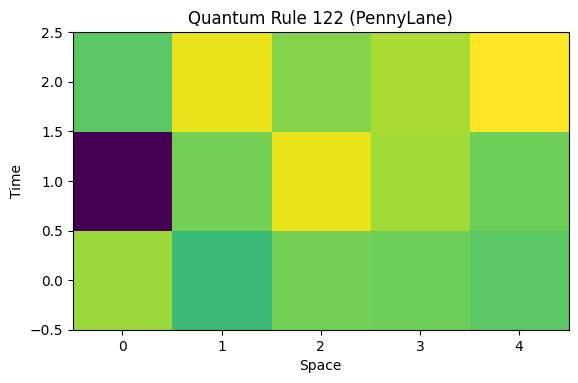

In [127]:
# Run circuit
samples = qca_rule122_circuit()

# Postprocess results into probability grid
grid = qnp.zeros((m, n))
for result in samples:
    for idx, bit in enumerate(result):
        if bit == 1:
            grid[idx // n, idx % n] += 1

# Normalize to get probabilities
grid /= shots

import matplotlib.pyplot as plt
# Visualize
plt.imshow(grid, cmap="viridis", interpolation='nearest')
plt.title("Quantum Rule 122 (PennyLane)")
plt.xlabel("Space")
plt.ylabel("Time")
plt.gca().invert_yaxis()  # match classical automata convention
plt.show()

## Comparison

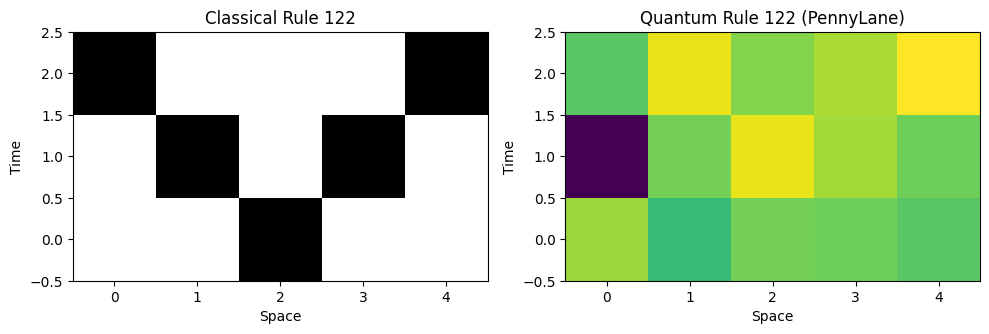

In [128]:
# Plot side-by-side
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(classical_rule122(), cmap="binary", interpolation='nearest')
axs[0].set_title("Classical Rule 122")
axs[1].imshow(grid, cmap="viridis", interpolation='nearest')
axs[1].set_title("Quantum Rule 122 (PennyLane)")
for ax in axs:
    ax.set_xlabel("Space")
    ax.set_ylabel("Time")
    ax.invert_yaxis()
plt.tight_layout()
plt.show()